### Libraries

In [1]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate

#Lema
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

#nlp count
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

### Load Data

In [2]:
query = "Query_AI-magazines-mediacloud-2021-24"

FEATHER_FILE = query + ".feather"
df = pd.read_feather('data/' + FEATHER_FILE)


In [3]:
df.shape

(2633, 14)

In [4]:
df['media_name'].value_counts()

media_name
wired.com               929
technologyreview.com    770
theverge.com            468
theatlantic.com         339
medium.com              109
thespectrum.com          18
Name: count, dtype: int64

In [5]:
df = df[df['media_name'] == 'technologyreview.com']

In [6]:
df.shape

(770, 14)

In [7]:
df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG
158,fdec091233661ec192c68a0f295b3280baee4386bb9fec...,2024-07-18 15:25:04.164166,en,technologyreview.com,technologyreview.com,2024-07-18,What’s next for SpaceX’s Falcon 9,https://www.technologyreview.com/2024/07/18/10...,2024,What’s next for SpaceX’s Falcon 9\nAn engine m...,True,"[US, US, US, California, US, US, US, Jiankui]","[Jonathan McDowell, SpaceX, Paulo Lozano, Loza...","[SpaceX, Falcon 9, MIT Technology Review, FAA,..."
1567,29f0e7a0fa121538c520a607847185ee0a0f724df57642...,2024-03-08 08:43:49.142255,en,technologyreview.com,technologyreview.com,2023-02-15,Inside the ChatGPT race in China,https://www.technologyreview.com/2023/02/15/10...,2023,Inside the ChatGPT race in China\nA Chinese Ch...,True,"[China, China, China, China, OpenAI, China, Ch...","[GPT-3, Hu Xijin, Hu Xijin, Secoo, Wang Huiwen...","[ChatGPT, ChatGPT, ChatGPT, ChatGPT, ChatGPT, ..."
920,e321de7fdae00d137b8632bfcd2e59f9fb8f74fbc85801...,2024-02-19 23:08:49.801436,en,technologyreview.com,technologyreview.com,2023-10-03,Turning medical data into actionable knowledge,https://www.technologyreview.com/2023/10/03/10...,2023,Sponsored\nTurning medical data into actionabl...,True,[],[Sam Altman],"[PACS, PACS, PACS, the Digital Imaging and Com..."


### Clean Data

In [8]:
df.columns

Index(['id', 'indexed_date', 'language', 'media_name', 'media_url',
       'publish_date', 'title', 'url', 'year', 'text', 'text_downloaded',
       'GPE', 'IND', 'ORG'],
      dtype='object')

### Lematization

In [9]:
nlp = spacy.load("en_core_web_sm")

In [10]:
df['text_clean'] = df['title'] + ' ' + df['text'] 

In [11]:
df['text_clean'] = df['text_clean'].fillna('').astype(str)


In [12]:
df.text[1]

'What impact will AI have on video game development?\nIt could make working conditions more bearable—or it could just put people out of work.\nThis story is from The Algorithm, our weekly newsletter on AI. To get it in your inbox first, sign up here.\nVideo game development has long been plagued by fear of the “crunch”—essentially, being forced to work overtime on a game to meet a deadline. In the early days of video games, the crunch was often viewed as a rite of passage: In the last days before release, an obsessed group of scrappy developers would work late into the night to perfect their dream game.\nHowever, nowadays the crunch is less likely to be glamorized than to be seen as a form of exploitation that risks causing mental illness and burnout. Part of the issue is that crunch time used to be just before a game launched, but now whole game development periods are “crunchy.” With games getting more expensive, companies are incentivized to make even more short-term profits by sque

In [13]:
# Custom words to remove
words = {'ai'}

# Function to parse the text
def parse_document(text):
    """
    Parses the text using spaCy.
    Returns a processed spaCy document.
    """
    return nlp(text)

# Function to clean tokens
def clean_tokens(doc):
    """
    Cleans tokens from the parsed document:
    - Filters tokens by POS tags: PROPN, NOUN, and optionally VERB.
    - Uses lemmatized forms (lemma_) instead of original text.
    - Excludes stopwords, punctuation, and custom-defined words.
    """
    tokens = [
        token.lemma_ for token in doc
        if token.pos_ in {"PROPN", "NOUN", "VERB"}  # Keep specific POS tags
        and token.text.lower() not in STOP_WORDS    # Exclude stopwords
        and token.is_alpha                          # Keep only alphabetic tokens
        and token.text.lower() not in string.punctuation  # Exclude punctuation
        and token.text.lower() not in words         # Exclude custom-defined words
    ]
    return tokens

In [14]:

df['parsed_doc'] = df['text_clean'].apply(parse_document)

In [15]:
df['clean_text'] = df['parsed_doc'].apply(lambda doc: ' '.join(clean_tokens(doc)))

In [16]:
df = df.drop('text_clean', axis=1)

In [17]:
df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,parsed_doc,clean_text
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,[Midjourney],"[Shawn Shan, Shawn Shan, Shawn Shan, Shan, Sha...","[Glaze, Nightshade, MIT Technology Review, the...","(2024, Innovator, of, the, Year, :, Shawn, Sha...",Innovator year Shawn Shan build tool help arti...
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,"[Midjourney, LA, Netherlands]","[Roblox, Roblox, AI, Niall, Josh Kahn]","[a16z, Ubisoft, ChatGPT, ChatGPT, AI, AI, AI, ...","(What, impact, will, AI, have, on, video, game...",impact video game development impact video gam...
10,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,"[Netherlands, Tech United, UK]","[René van de Molengraft, Van de Molengraft, Va...","[Eindhoven University of Technology, RoboCup, ...","(To, be, more, useful, ,, robots, need, to, be...",robot need robot need Smarter datum processing...
14,6e756b42d864508050ba087a650179d05ac91be0b4855d...,2024-09-06 18:23:28.427532,en,technologyreview.com,technologyreview.com,2024-09-06,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,True,"[France, Paris]","[Marcus Holmström, GPT-4, Roblox, Anupam Singh...","[The Gang, Roblox, AI, Roblox, AI, Kent State ...","(Roblox, is, launching, a, generative, AI, tha...",roblox launch build environment Roblox launch ...
19,3ac10c795421811068dff2c020f48849fad908cb32cb47...,2024-09-05 15:28:38.006311,en,technologyreview.com,technologyreview.com,2024-09-05,Integrating security from code to cloud,https://www.technologyreview.com/2024/09/05/10...,2024,Sponsored\nIntegrating security from code to c...,True,"[withMicrosoft, Jiankui]","[David Harmon, Vlad Korsunsky, Harmon, Flexera...","[AMD, The Human Genome Project, SpaceX, Tesla,...","(Integrating, security, from, code, to, cloud,...",integrate security code cloud Sponsored Integr...


In [18]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

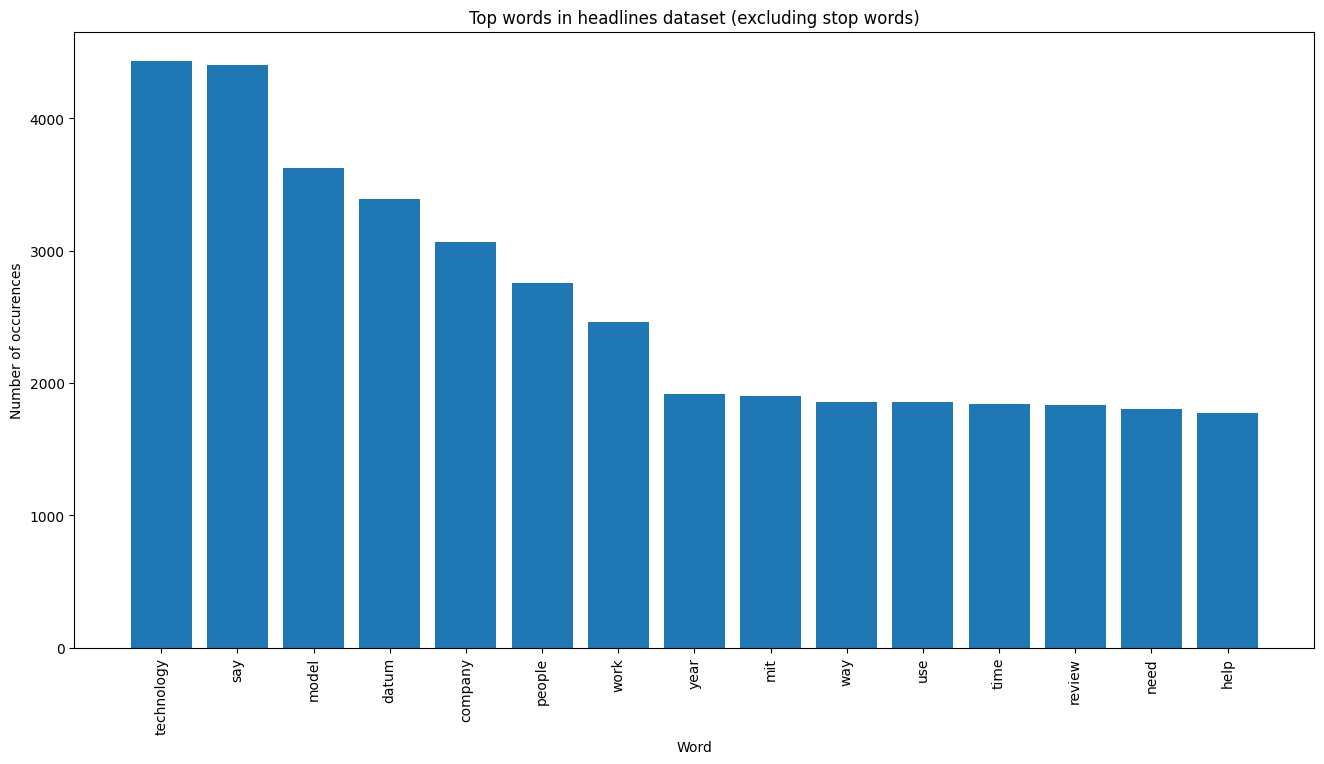

In [19]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['clean_text'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [20]:
df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,parsed_doc,clean_text
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,[Midjourney],"[Shawn Shan, Shawn Shan, Shawn Shan, Shan, Sha...","[Glaze, Nightshade, MIT Technology Review, the...","(2024, Innovator, of, the, Year, :, Shawn, Sha...",Innovator year Shawn Shan build tool help arti...
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,"[Midjourney, LA, Netherlands]","[Roblox, Roblox, AI, Niall, Josh Kahn]","[a16z, Ubisoft, ChatGPT, ChatGPT, AI, AI, AI, ...","(What, impact, will, AI, have, on, video, game...",impact video game development impact video gam...
10,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,"[Netherlands, Tech United, UK]","[René van de Molengraft, Van de Molengraft, Va...","[Eindhoven University of Technology, RoboCup, ...","(To, be, more, useful, ,, robots, need, to, be...",robot need robot need Smarter datum processing...
14,6e756b42d864508050ba087a650179d05ac91be0b4855d...,2024-09-06 18:23:28.427532,en,technologyreview.com,technologyreview.com,2024-09-06,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,True,"[France, Paris]","[Marcus Holmström, GPT-4, Roblox, Anupam Singh...","[The Gang, Roblox, AI, Roblox, AI, Kent State ...","(Roblox, is, launching, a, generative, AI, tha...",roblox launch build environment Roblox launch ...
19,3ac10c795421811068dff2c020f48849fad908cb32cb47...,2024-09-05 15:28:38.006311,en,technologyreview.com,technologyreview.com,2024-09-05,Integrating security from code to cloud,https://www.technologyreview.com/2024/09/05/10...,2024,Sponsored\nIntegrating security from code to c...,True,"[withMicrosoft, Jiankui]","[David Harmon, Vlad Korsunsky, Harmon, Flexera...","[AMD, The Human Genome Project, SpaceX, Tesla,...","(Integrating, security, from, code, to, cloud,...",integrate security code cloud Sponsored Integr...


### Save clean text

In [21]:
df.to_csv('Query_AI_text_clean.csv', index=False)

### Analysis

In [22]:
df = pd.read_csv('Query_AI_text_clean.csv')

In [23]:
df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,parsed_doc,clean_text
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,['Midjourney'],['Shawn Shan' 'Shawn Shan' 'Shawn Shan' 'Shan'...,['Glaze' 'Nightshade' 'MIT Technology Review' ...,2024 Innovator of the Year: Shawn Shan builds ...,Innovator year Shawn Shan build tool help arti...
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,['Midjourney' 'LA' 'Netherlands'],['Roblox' 'Roblox' 'AI' 'Niall' 'Josh Kahn'],['a16z' 'Ubisoft' 'ChatGPT' 'ChatGPT' 'AI' 'AI...,What impact will AI have on video game develop...,impact video game development impact video gam...
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,['Netherlands' 'Tech United' 'UK'],['René van de Molengraft' 'Van de Molengraft' ...,['Eindhoven University of Technology' 'RoboCup...,"To be more useful, robots need to become lazie...",robot need robot need Smarter datum processing...


In [24]:
df.shape

(770, 16)

In [25]:
df['clean_text'].isnull().sum()

np.int64(1)

In [26]:
df = df.dropna(subset=['clean_text'])

### Temperature

In [27]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,parsed_doc,clean_text,temperature,color
598,38d9099fe08451477c3c5a819c896a1ec1639746fd1c1c...,2024-05-08 06:34:56.007120,en,technologyreview.com,technologyreview.com,2022-06-15,Building tomorrow’s telecommunications network...,https://www.technologyreview.com/2022/06/15/10...,2022,NaN,False,[],[],[],Building tomorrow’s telecommunications network...,building tomorrow telecommunication network today,0,#aa0055
335,13021e8422e89f6bdaec84071bb8d5672f8d63a8f14115...,2024-02-23 06:24:01.259253,en,technologyreview.com,technologyreview.com,2023-08-07,AI language models are rife with different pol...,https://www.technologyreview.com/2023/08/07/10...,2023,AI language models are rife with different pol...,True,['US' 'Park'],['GPT-3 Ada' 'GPT-3 Da Vinci' 'GPT-4' 'Chan Pa...,['OpenAI' 'GPT-2' 'the University of Washingto...,AI language models are rife with different pol...,language model bias language model bias resear...,1,#5500aa
296,c798ce4ec8a982e408e07f3dd50ab399ddd69c44af14ce...,2024-02-20 09:30:35.937895,en,technologyreview.com,technologyreview.com,2023-09-25,These new tools could make AI vision systems l...,https://www.technologyreview.com/2023/09/25/10...,2023,These new tools could make AI vision systems l...,True,['ICCV'],['Fitzpatrick' 'William Thong' 'Alice Xiang' '...,['Sony' 'Meta' 'Sony' 'Meta' 'AI' 'AI' 'Sony' ...,These new tools could make AI vision systems l...,tool vision system bias tool vision system pap...,1,#5500aa


In [28]:
df.shape

(769, 18)

In [29]:
df = df.dropna(subset=['year'])
df = df.dropna(subset=['clean_text'])

### Term Frequency

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=lambda key: key,  # Use if 'entities' is a list of lists
    token_pattern=None  # Disable token_pattern since we are using a custom tokenizer
)

# Convert 'entities' column (which is a list of lists) to a list
entities = df["clean_text"].to_list()

# Vectorize the list of entities
X = vectorizer.fit_transform(entities)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)

df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,parsed_doc,clean_text,temperature,color
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,['Midjourney'],['Shawn Shan' 'Shawn Shan' 'Shawn Shan' 'Shan'...,['Glaze' 'Nightshade' 'MIT Technology Review' ...,2024 Innovator of the Year: Shawn Shan builds ...,Innovator year Shawn Shan build tool help arti...,2,#0000ff
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,['Midjourney' 'LA' 'Netherlands'],['Roblox' 'Roblox' 'AI' 'Niall' 'Josh Kahn'],['a16z' 'Ubisoft' 'ChatGPT' 'ChatGPT' 'AI' 'AI...,What impact will AI have on video game develop...,impact video game development impact video gam...,2,#0000ff
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,['Netherlands' 'Tech United' 'UK'],['René van de Molengraft' 'Van de Molengraft' ...,['Eindhoven University of Technology' 'RoboCup...,"To be more useful, robots need to become lazie...",robot need robot need Smarter datum processing...,2,#0000ff


## UMAP

c:\Users\UserAlba\anaconda3\envs\visual_studio_code\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


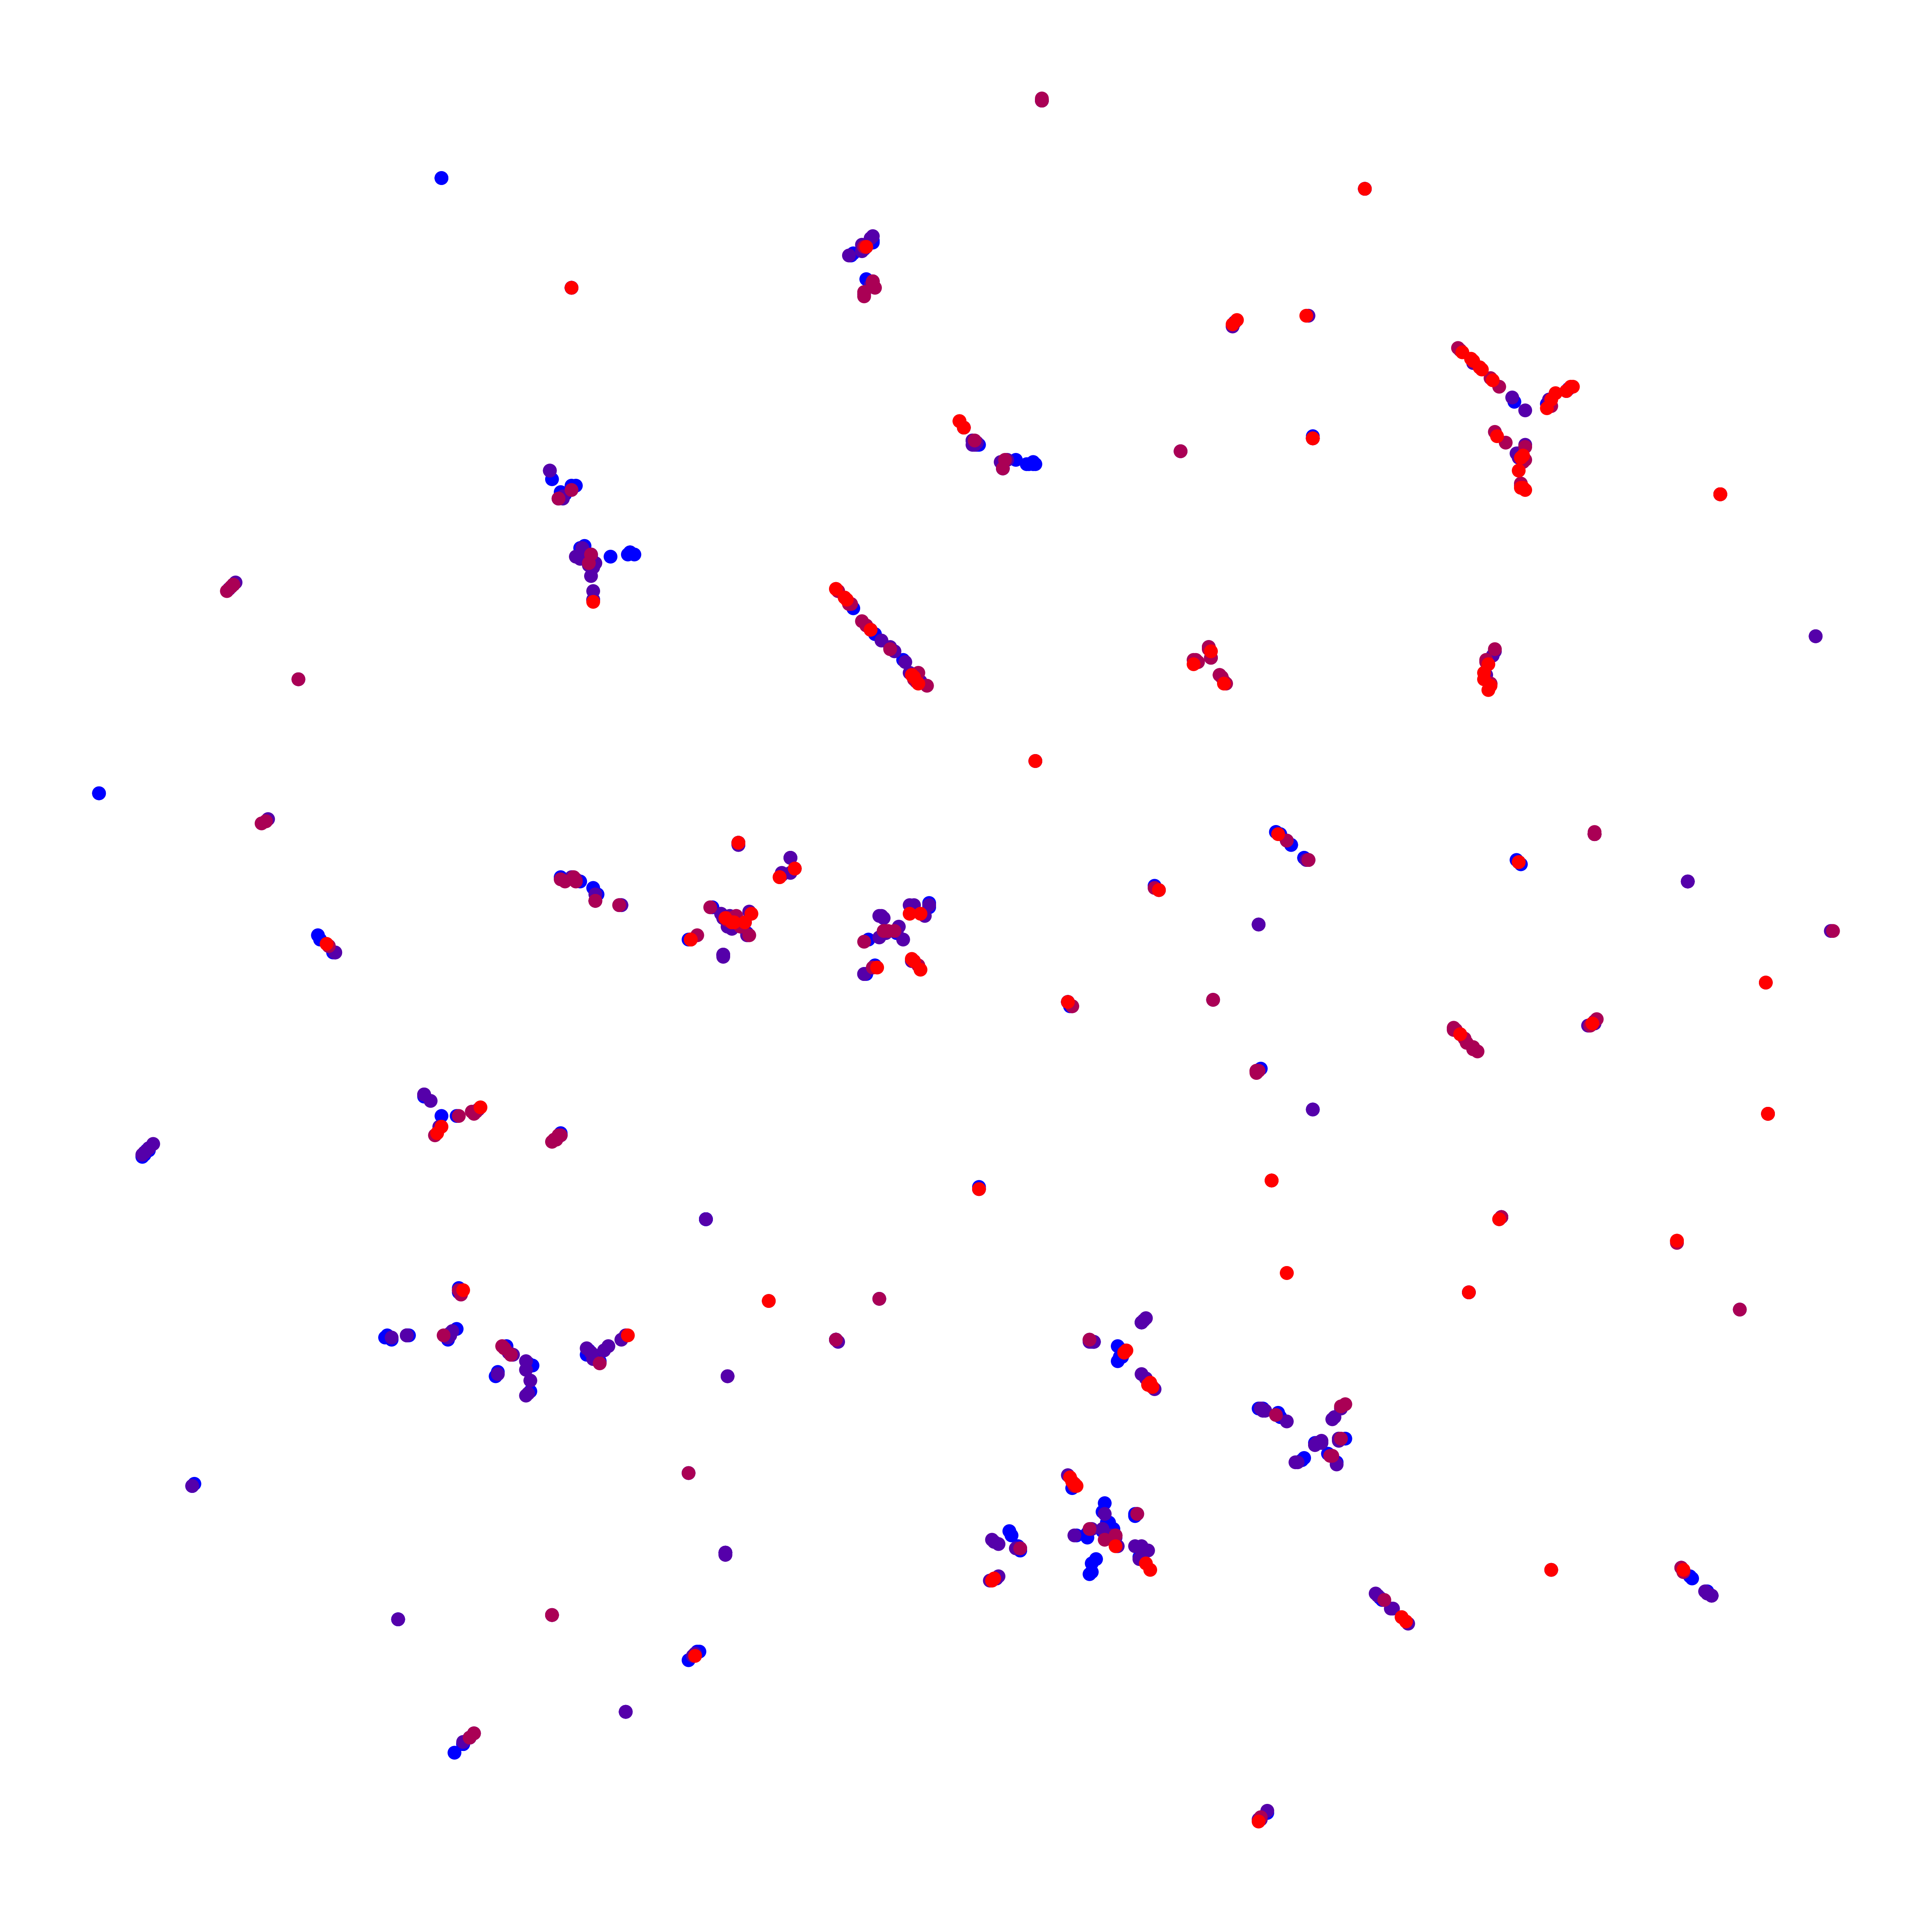

In [35]:
# Fit UMAP reducer without random_state for parallelism
reducer = umap.UMAP(
    random_state=2,
    n_components=2,
    n_neighbors=2,
    min_dist=0.1,
    metric="hellinger"
)

embedding = reducer.fit_transform(train_data) # run UMAP



scaler = MinMaxScaler(feature_range=(100, 900)) # Scale embeddings to a fixed range (100 to 900)
embedding_scaled = scaler.fit_transform(embedding)
embedding_scaled = embedding_scaled.astype(int)

# embedding_scaled = align_points_to_grid(embedding_scaled)  # Alignment to a grid

# Assign embeddings (x, y) back to 'entities' DataFrame
index_embedding = 0

for index, row in df.iterrows():
    df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
    df.loc[index, "y"] = embedding_scaled[:, 1][index_embedding]
    index_embedding += 1

# Plotting
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot with size based on 'frequency' and color from 'color'
plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=50,
    c=df["color"].to_list(),
)

# Labels
# for i, row in df.iterrows():
#     text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
#     text.set_fontsize(3)  # Adjust if too small

# Save the plot
plt.savefig("download.png")

## Clustering

In [36]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=10,            # Aumenta el número de clusters reduciendo los puntos necesarios para un área densa
    min_cluster_size=10,       # Tamaño mínimo del cluster; si lo reduces, obtendrás más clusters
    # cluster_selection_epsilon=0.4  # Controla la fusión de clusters cercanos. Reducirlo puede ayudar a obtener más clusters.
)

df["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, df):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            df.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            df.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    df.loc[(df["temperature"] > 0)],
    "p_",
    df,
)
cluster_computing(
    df.loc[(df["temperature"] <= 0)],
    "n_",
    df,
)

df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,GPE,IND,ORG,parsed_doc,clean_text,temperature,color,x,y,cluster
118,a89acdf4c3b95bfcc063b517bd55302482174581f314f9...,2024-05-13 15:20:41.023107,en,technologyreview.com,technologyreview.com,2024-05-13,"The Download: the future of chips, and investi...",https://www.technologyreview.com/2024/05/13/10...,2024,"The Download: the future of chips, and investi...",...,['US' 'America' 'US' 'China' 'India' 'UK' 'Ame...,['James O’Donnell' 'Eric Schmidt' 'Eric Schmid...,['Apollo' 'Google' 'Schmidt Futures' 'OpenAI' ...,"The Download: the future of chips, and investi...",Download future chip invest Download future ch...,2,#0000ff,266,345,p_16
427,6dede955f4be58f72d4e5d8dcba29311e966b1e07b706c...,2024-03-01 10:32:45.594276,en,technologyreview.com,technologyreview.com,2023-04-03,Three ways AI chatbots are a security disaster,https://www.technologyreview.com/2023/04/03/10...,2023,Three ways AI chatbots are a security disaster...,...,['Germany'],['Bing' 'Florian Tramèr' 'Arvind Narayanan' 'N...,['ChatGPT' 'Bard' 'ChatGPT' 'Reddit' 'OpenAI' ...,Three ways AI chatbots are a security disaster...,way chatbot security disaster way chatbot secu...,1,#5500aa,833,536,p_2
598,38d9099fe08451477c3c5a819c896a1ec1639746fd1c1c...,2024-05-08 06:34:56.007120,en,technologyreview.com,technologyreview.com,2022-06-15,Building tomorrow’s telecommunications network...,https://www.technologyreview.com/2022/06/15/10...,2022,NaN,...,[],[],[],Building tomorrow’s telecommunications network...,building tomorrow telecommunication network today,0,#aa0055,535,900,-1


{'p_0', 'p_2', 'p_4', 'n_2', 'p_5', 'p_14', 'p_6', 'n_6', 'p_10', 'p_7', 'p_11', 'n_5', '-1', 'n_7', 'n_0', 'p_8', 'n_1', 'p_12', 'p_9', 'p_15', 'p_1', 'p_3', 'p_16', 'n_3', 'p_13', 'n_8', 'n_4'}


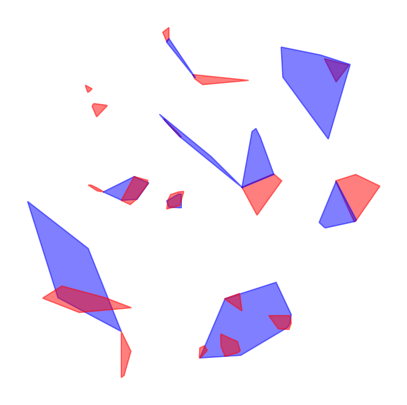

In [37]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(df["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = df.loc[df["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    if len(points) < 3:
        print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#FF0000", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#0000FF", alpha=0.5)  # Plot blue


# Save

In [38]:
export = df.copy()

# export = export.drop(columns="entities")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,GPE,IND,ORG,parsed_doc,clean_text,temperature,color,x,y,cluster
567,f424011c188885efb2ff5aa5b2a29aabf589515a51b2d8...,2024-05-04 23:45:20.615557,en,technologyreview.com,technologyreview.com,2022-07-28,DeepMind has predicted the structure of almost...,https://www.technologyreview.com/2022/07/28/10...,2022,DeepMind has predicted the structure of almost...,...,['Sora'],['Demis Hassabis' 'Jian Peng' 'Hassabis' 'Moha...,['AlphaFold' 'Alphabet' 'AlphaFold' 'AlphaFold...,DeepMind has predicted the structure of almost...,DeepMind predict structure protein know scienc...,0,#aa0055,372,261,n_0


# Explorin the clusters

In [39]:
df['cluster'].value_counts()

cluster
-1      219
p_16     52
n_8      40
p_10     34
n_2      31
p_8      30
p_13     29
n_0      25
n_6      24
p_12     23
p_9      22
n_3      22
p_1      21
p_5      20
p_11     18
n_4      17
p_4      15
p_7      15
n_7      15
p_0      13
p_2      13
p_3      13
p_14     12
n_5      12
p_15     12
p_6      11
n_1      11
Name: count, dtype: int64

In [40]:
df['cluster'].nunique()

27

In [42]:
import random

In [57]:
# Filter the headlines belonging to cluster 
cluster_id = 'p_3'
cluster_headlines = df[df['cluster'] == cluster_id]['title']

# Randomly select 10 headlines (or less if there aren't enough) with the seed directly in the same line
random_headlines = random.Random(0).sample(cluster_headlines.tolist(), min(10, len(cluster_headlines)))

# Convert the list of headlines into a string to pass to the API
headlines_text = "\n".join(random_headlines)
print(headlines_text)

AI gains momentum in core manufacturing services functions
Inside Tencent’s weirdly secretive customer service center
A playbook for crafting AI strategy
Taking AI to the next level in manufacturing
Data analytics reveal real business value
Laying the foundation for data- and AI-led growth
AI-readiness for C-suite leaders
The data practitioner for the AI era
Making data matter in real time
Bringing breakthrough data intelligence to industries


In [47]:
df['color'].value_counts()

color
#5500aa    262
#0000ff    220
#aa0055    172
#ff0000    115
Name: count, dtype: int64

In [ ]:
#Filter by colour

selected_color = '#ff0000'
unique_clusters = df.loc[df['color'] == selected_color, 'cluster'].unique()
if unique_clusters.size > 0:
    print(f"The unique clusters for color {selected_color} are: {list(unique_clusters)}")
else:
    print(f"Color {selected_color} not found in the dataset.")


The unique clusters for color #ff0000 are: ['n_1', 'n_8', 'n_7', 'n_2', 'n_6', 'n_5', '-1', 'n_4', 'n_3', 'n_0']
